In [2]:
import mdtraj as mda
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

data_path = './data/dump-surface.lammpstrj'

layer_num = 40

max_pos, min_pos = None, None

In [3]:
class H2O :
	def __init__ (self, pO : np.ndarray, pH1 : np.ndarray, pH2 : np.ndarray) :
		self.pO = pO
		self.pH1 = pH1
		self.pH2 = pH2

		def fix_pH(pH) :
			dis = abs(pH - pO)
			for i in range(3) :
				if dis[i] > (max_pos[i] - min_pos[i]) / 2 :
					if pH[i] > pO[i] :
						pH[i] -= (max_pos[i] - min_pos[i])
					else :
						pH[i] += (max_pos[i] - min_pos[i])

		if np.linalg.norm(pO - pH1) > 20 :
			fix_pH(pH1)
		if np.linalg.norm(pO - pH2) > 20 :
			fix_pH(pH2)

def toArr(h2o : list[H2O]) -> tuple[np.ndarray, np.ndarray, np.ndarray] :
	n = len(h2o)
	pO = np.zeros((n, 3))
	pH1 = np.zeros((n, 3))
	pH2 = np.zeros((n, 3))
	h2o = sorted(h2o, key=lambda x: x.pO[2])
	for i in range(n) :
		pO[i, :] = h2o[i].pO
		pH1[i, :] = h2o[i].pH1
		pH2[i, :] = h2o[i].pH2
	return pO, pH1, pH2


# Load Data

In [4]:
data_raw : list[str]

with open(data_path, 'r') as f:
	data_raw = f.readlines()

data_raw = [line.strip() for line in data_raw]

cur_frame : list[H2O] = None
frames : list[tuple[np.ndarray, np.ndarray, np.ndarray]] = []

line_id = 0

process = tqdm(total=len(data_raw), desc="Parsing LAMMPS trajectory")
while line_id < len(data_raw) :
	cur_line = data_raw[line_id].strip()
	if cur_line.startswith("ITEM: TIMESTEP") :
		if cur_frame is not None :
			frames.append(toArr(cur_frame))
		cur_frame = []
		if min_pos is None :
			min_pos = np.zeros(3)
			max_pos = np.zeros(3)
			for x in range(3) :
				a, b = data_raw[line_id + 5 + x].strip().split()
				min_pos[x], max_pos[x] = float(a), float(b)
		line_id += 9
		process.update(9)
		continue
	def get_pos(line : str, type : int) -> np.ndarray :
		parts = line.strip().split()
		# print(parts)
		assert type == int(parts[1]), f"Expected type {type}, got {parts[1]}"
		return np.array([float(parts[2]), float(parts[3]), float(parts[4])])
	pO = get_pos(data_raw[line_id], 1)
	pH1 = get_pos(data_raw[line_id + 1], 2)
	pH2 = get_pos(data_raw[line_id + 2], 2)
	cur_frame.append(H2O(pO, pH1, pH2))
	process.update(3)
	line_id += 3

process.close()
assert max([frame_h2o[0].shape[0] for frame_h2o in frames]) == min([frame[0].shape[0] for frame in frames]), \
	"Number of H2O molecules must be consistent across frames."

print(f"Total frames parsed: {len(frames)} with {frames[0][0].shape[0]} H2O molecules each.")

print("box bounds:", min_pos, max_pos)

Parsing LAMMPS trajectory: 100%|██████████| 6357177/6357177 [00:13<00:00, 465190.64it/s]

Total frames parsed: 2000 with 1056 H2O molecules each.
box bounds: [-14.14213562 -14.14213562 -40.        ] [14.14213562 14.14213562 40.        ]


# Split Layers

In [28]:
def layer_upper(layer_idx : int) -> float :
	return min_pos[2] + (max_pos[2] - min_pos[2]) * (layer_idx + 1) / layer_num

def layer_lower(layer_idx : int) -> float :
	return layer_upper(layer_idx - 1)

# divide into layers
layers : list[list[np.ndarray]]= [[] for _ in range(layer_num)]  # layers[layer_idx][frame_idx] = list of H2O in that layer at that frame

for layer_idx in range(layer_num) :
	low, high = layer_lower(layer_idx), layer_upper(layer_idx)
	for frame_idx in range(len(frames)) :
		pO, pH1, pH2 = frames[frame_idx]
		mask = (pO[:, 2] >= low) & (pO[:, 2] < high)
		layers[layer_idx].append((pO[mask], pH1[mask], pH2[mask]))

# compute number of H-bonds
# for each two melecules, if the distance between O and H is less than 2.5A and the angle O-H...O is less than 30 degrees, then it's a H-bond

hb_dist = 3.5
hb_rad = np.cos(np.deg2rad(30))
hb_counts : list[list[int]] = [[0 for _ in range(len(frames))] for _ in range(layer_num)]  # hb_counts[layer_idx][frame_idx] = number of H-bonds in that layer at that frame
me_counts : list[list[int]] = [[0 for _ in range(len(frames))] for _ in range(layer_num)]  # me_counts[layer_idx][frame_idx] = number of molecules in that layer at that frame

# calculate H-bonds provided by each H2O molecule
for frame_id, frame in enumerate(frames) :
	for i in range(frame[0].shape[0]) :
		z_max = frame[0][i, 2] + hb_dist
		z_min = frame[0][i, 2] - hb_dist
		mask = ((frame[0][:, 2] >= z_min) & (frame[0][:, 2] <= z_max)) ^ (np.arange(frame[0].shape[0]) == i)
		masked_frame = (frame[0][mask], frame[1][mask], frame[2][mask])
		dis = np.linalg.norm(masked_frame[0] - frame[0][i], axis=1)
		u1 = frame[1][i] - frame[0][i]
		u2 = frame[2][i] - frame[0][i]
		u1 /= np.linalg.norm(u1)
		u2 /= np.linalg.norm(u2)

		u = masked_frame[0] - frame[0][i]
		u_norm = np.linalg.norm(u, axis=1, keepdims=True)
		u = u / (u_norm + 1e-8)

		u3 = masked_frame[1] - masked_frame[0]
		u4 = masked_frame[2] - masked_frame[0]
		u3 /= np.linalg.norm(u3, axis=1, keepdims=True)
		u4 /= np.linalg.norm(u4, axis=1, keepdims=True)

		cos_theta1 = np.dot(u, u1)
		cos_theta2 = np.dot(u, u2)
		cos_theta3 = (-u * u3).sum(axis=1)
		cos_theta4 = (-u * u4).sum(axis=1)

		layer_id = int((frame[0][i, 2] - min_pos[2]) / (max_pos[2] - min_pos[2]) * layer_num)
		mask_hb = (dis < hb_dist) & ((cos_theta1 < hb_rad) | (cos_theta2 < hb_rad) | (cos_theta3 < hb_rad) | (cos_theta4 < hb_rad))
		hb_counts[layer_id][frame_id] += np.sum(mask_hb)  # exclude self-bonding
		me_counts[layer_id][frame_id] += 1

	
for layer_idx in range(layer_num) :
	hb_counts[layer_idx] = np.array(hb_counts[layer_idx])
	me_counts[layer_idx] = np.array(me_counts[layer_idx])

print("H-bond calculation completed.")

H-bond calculation completed.


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.21901675983271, 523.6155684288777, 0.28388394028681746, 0.08873512545376373, 0.08026437743022077, 0.08457952117248613, 0.08635322253139203, 0.08574575279193081, 0.08609665889254838, 0.08579934624776843, 0.08619335034400438, 0.08627177951556277, 0.08591257536480067, 0.08597974537073566, 0.08583435992933212, 0.0864180347276888, 0.08555723944904886, 0.08626562079154408, 0.0857781554328331, 0.08590427468983211, 0.08517666469688608, 0.07956819227171437, 0.09146630347828752, 0.31524024119294153, 516.1231740329272, 9.419401777044135, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


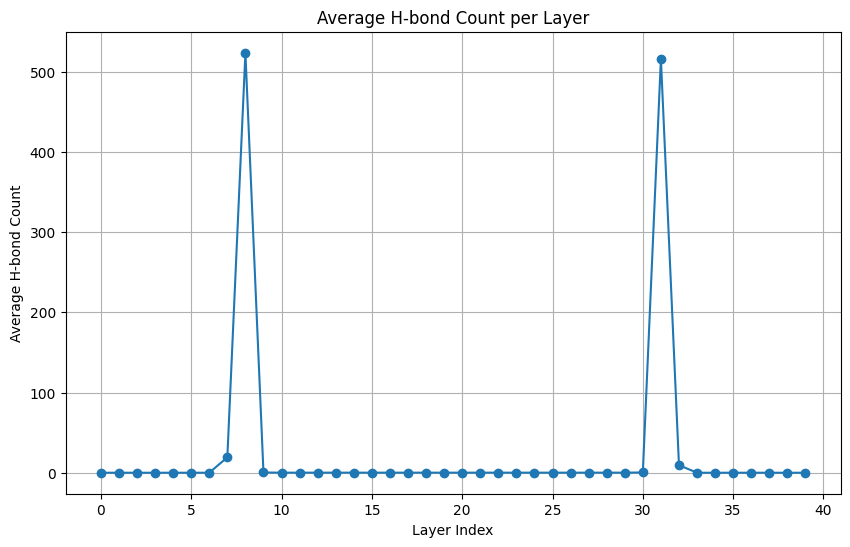

In [ ]:
hb_counts_avg : list[float] = [0.0 for _ in range(layer_num)]
for i in range(layer_num) :
	hb_counts_avg[i] = np.array(hb_counts[i] / (me_counts[i] + 1e-3)).mean().item()
print(hb_counts)
# plot the H-bond counts
plt.figure(figsize=(10, 6))
plt.plot(range(layer_num), hb_counts, marker='o')
plt.xlabel('Layer Index')
plt.ylabel('Average H-bond Count')
plt.title('Average H-bond Count per Layer')
plt.grid()